In [96]:
from hcipy import *
import numpy as np  
import matplotlib.pyplot as plt
from aotools.aotools import *


## PSF, diffraction, etc.

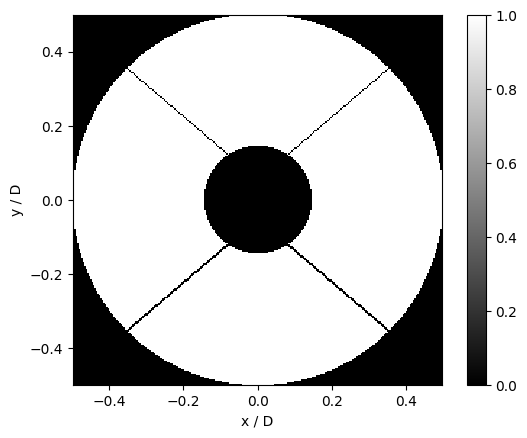

In [97]:
pupil_grid = make_pupil_grid(256)  # make_pupil_grid returns cartesian coordinates

telescope_pupil_generator = make_magellan_aperture(normalized=True)

telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()



[0. 0. 0. ... 0. 0. 0.]
[[-3.23730469 -3.23730469]
 [-3.21191406 -3.23730469]
 [-3.18652344 -3.23730469]
 ...
 [ 3.18652344  3.23730469]
 [ 3.21191406  3.23730469]
 [ 3.23730469  3.23730469]]
<class 'hcipy.field.field.OldStyleField'>
(65536,)
[0.00000000e+00 1.52590219e-04 3.05180438e-04 ... 9.99969482e+00
 9.99984741e+00 1.00000000e+01]


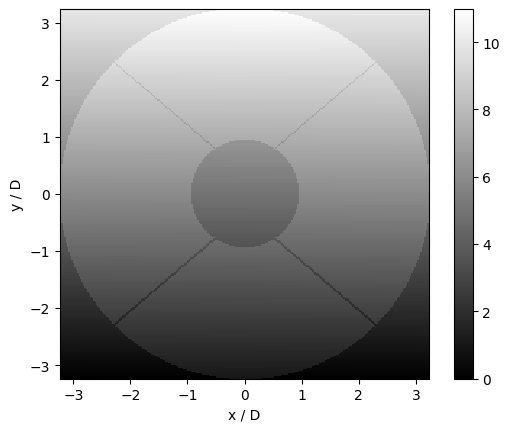

[[-3.23730469 -3.23730469]
 [-3.21191406 -3.23730469]
 [-3.18652344 -3.23730469]
 ...
 [ 3.18652344  3.23730469]
 [ 3.21191406  3.23730469]
 [ 3.23730469  3.23730469]]


In [104]:
print(telescope_pupil)
print(telescope_pupil.grid.points) # the position/coordinates of the grid points
print(type(telescope_pupil))
print(telescope_pupil.shape)
print(telescope_pupil + np.linspace(0,10,65536))  # these are kind of like the flux values at the grid points
imshow_field(telescope_pupil + np.linspace(0,10,65536), cmap='gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

# print(telescope_pupil.points) # gives error as it is a field object
print(telescope_pupil.grid.points) # this works



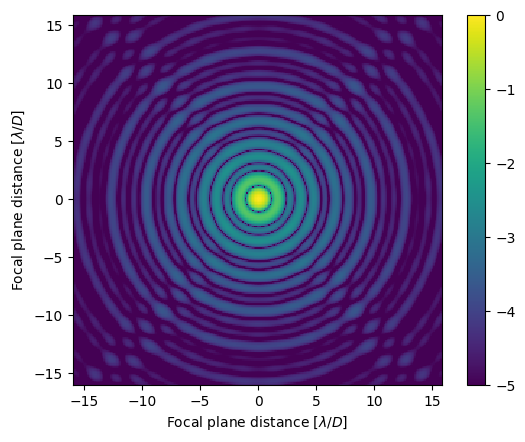

<class 'hcipy.propagation.fraunhofer.FraunhoferPropagator'>
<class 'hcipy.optics.wavefront.Wavefront'>


In [99]:
# the telescope_pupil Field basically gives the illuminaion of the pupil plane of the telescope just after getting reflected by the primary mirror
# Wavefront converts it into "light"

wavefront = Wavefront(telescope_pupil) # wavelength=1m default

focal_grid = make_focal_grid(q=8, num_airy=16)

# This function takes `q`, which is the number of pixels per diffraction width (spatial_resolution/pixel_size), and 
# `num_airy`, which is half size (ie. radius) of the image in the number of diffraction widths. 
# I am not very sure about these two. how to derive them.

prop = FraunhoferPropagator(pupil_grid, focal_grid)

focal_image = prop.forward(wavefront)

imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

print(prop)
print(type(prop))
print(focal_image)
print(type(focal_image))


[2.66439101e-06 2.76537984e-06 2.52710145e-06 ... 5.01845738e-07
 7.89388019e-07 1.07339402e-06]
<class 'hcipy.field.field.OldStyleField'>


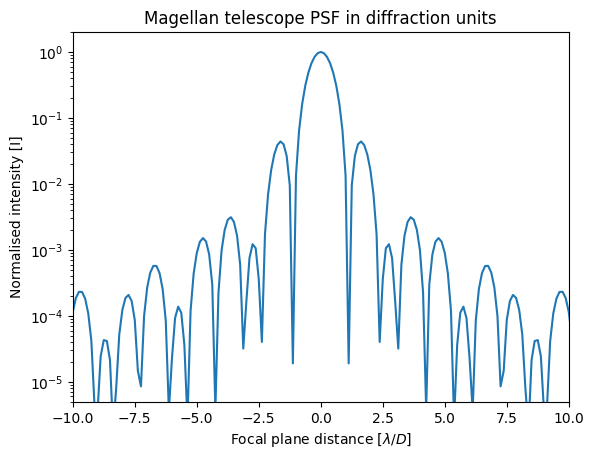

In [100]:
psf = focal_image.intensity
print(psf)
print(type(psf))
psf_shape = psf.grid.shape

slicefoc = psf.shaped[:, psf_shape[0] // 2]
slicefoc_normalised = slicefoc / psf.max()

plt.plot(focal_grid.x.reshape(psf_shape)[0, :], slicefoc_normalised)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Normalised intensity [I]')
plt.yscale('log')
plt.title('Magellan telescope PSF in diffraction units')
plt.xlim(-10, 10)
plt.ylim(5e-6, 2)
plt.show()

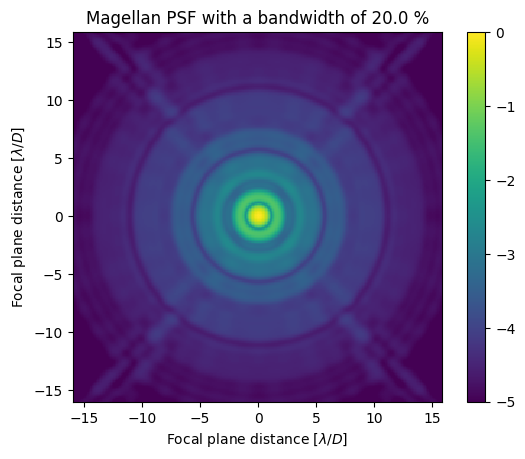

In [101]:
bandwidth = 0.2

focal_total = 0
for wlen in np.linspace(1 - bandwidth / 2., 1 + bandwidth / 2., 11):
    wavefront = Wavefront(telescope_pupil, wlen)
    focal_total += prop(wavefront).intensity  

# basically adding up the contributions from all the different wavelengths    

imshow_field(np.log10(focal_total / focal_total.max()), vmin=-5)

plt.title('Magellan PSF with a bandwidth of {:.1f} %'.format(bandwidth * 100))
plt.colorbar()
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.show()

In [102]:
# in proper theoretical sense, the total intensity on the focal plane should not just be the addition of the different wavelengths intensity
# there should additionally be an interference term.
# but this is not present here.
# why? is it complicated to implement that?
# i think its about coherence. two stars are very much incoherent?
# shouldnt the 2 stars 

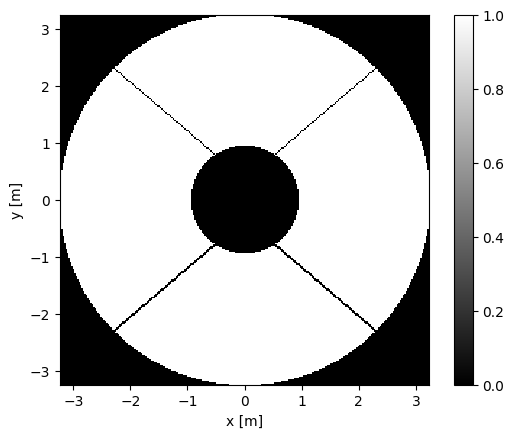

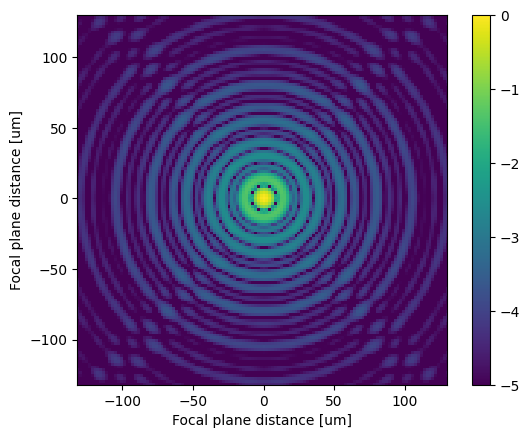

In [103]:
pupil_diameter = 6.5 # m
effective_focal_length = 71.5 # m
wavelength = 750e-9 # m

pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)

telescope_pupil_generator = make_magellan_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

wavefront = Wavefront(telescope_pupil, wavelength)

focal_grid = make_focal_grid(q=4, num_airy=16, pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

focal_image = prop.forward(wavefront)

imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()